# Problem 6

## GNN for node classification and link prediction

In [1]:
# Import the libraries

import numpy as np
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

import torch
import matplotlib.pyplot as plt

from torch_geometric.datasets import Planetoid

from models_utils import GCNNet, SAGENet, GATNet, EncoderDecoder
from train_utils import node_classification_train_loop, node_classification_test
from train_utils import edge_splitting, encoder_decoder_train_loop, test_encoder_decoder

import networkx as nx 

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

In [2]:
dataset = Planetoid(root='/data', name='PubMed')

In [3]:
print(dataset.num_features)
print(dataset.num_classes)

500
3


In [4]:
data = dataset[0]

# Let's have a look to how data are structured

data

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

## Exploratory data analysis

#### Network structure

First of all, let's build the graph underlying our dataset to retrieve some precious informations. 

In [5]:
nodes = torch.arange(0, data.x.shape[0])
edges = data.edge_index

Let's remap the tensor containing the edges to a data structure digestible by ```NetworkX```, that requires the edges to be 2-tuples:

In [6]:
edges

tensor([[ 1378,  1544,  6092,  ..., 12278,  4284, 16030],
        [    0,     0,     0,  ..., 19714, 19715, 19716]])

In [7]:
edges_tail = edges[0,:]
edges_head = edges[1,:]

edges = [(edges_tail[i].item(), edges_head[i].item()) for i in range(edges.shape[1])]

In [8]:
Es = {e:0 for e in edges}
edges_ = []

for e in tqdm(edges):
    if Es[(e[0],e[1])] == 0 and Es[(e[1],e[0])] == 0:
        edges_.append(e)
        Es[(e[0],e[1])] = 1
        Es[(e[1],e[0])] = 1

100%|██████████| 88648/88648 [00:00<00:00, 1363344.12it/s]


In [9]:
PubMed_graph = nx.Graph()

PubMed_graph.add_nodes_from(nodes.detach().numpy())
PubMed_graph.add_edges_from(edges_)

Let's first of all have a look to the plain characteristics of the network:

In [10]:
print(f'There are {len(nodes)} nodes in the network')
print(f'There are {len(edges_)} edges in the network')

There are 19717 nodes in the network
There are 44324 edges in the network


We expect the degree distribution to follow a power-law in the loglog scale and the network to be quite sparse:

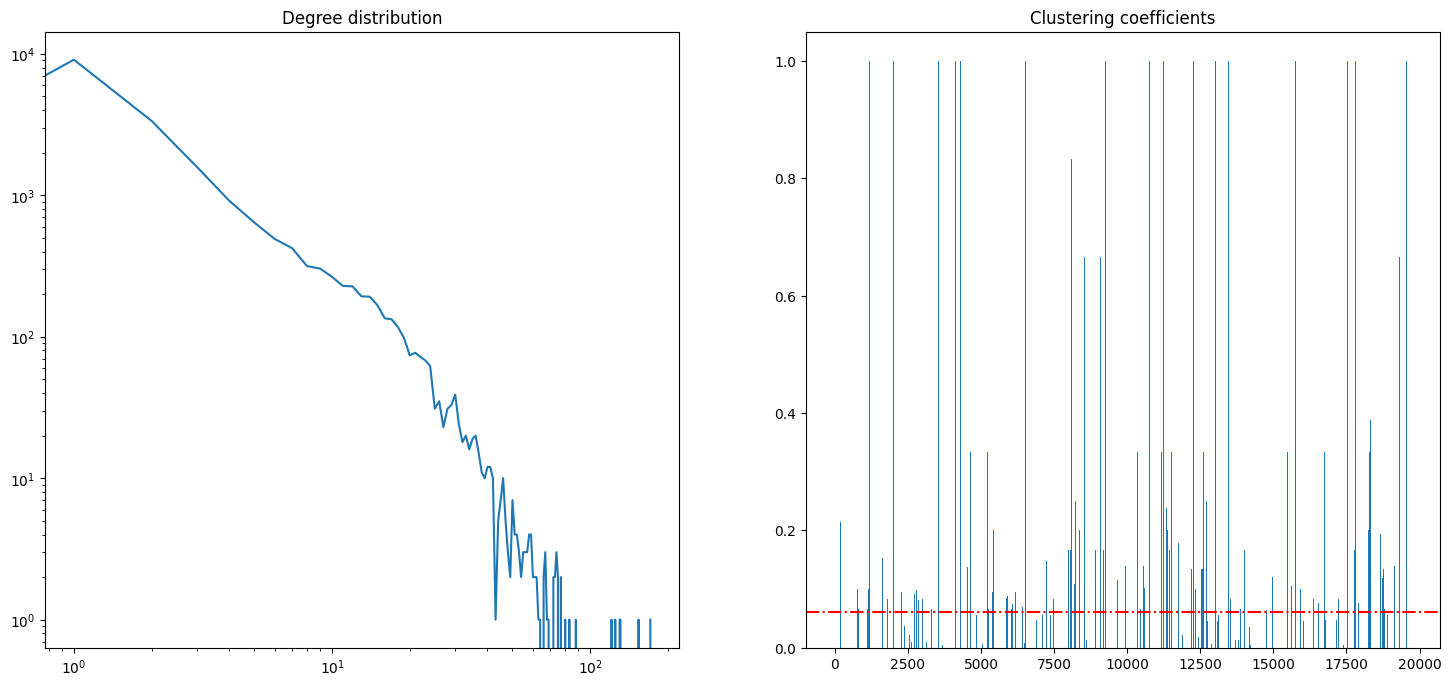

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
axs[0].plot(nx.degree_histogram(PubMed_graph))
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].title.set_text('Degree distribution')

axs[1].bar(list(nx.clustering(PubMed_graph).keys()), list(nx.clustering(PubMed_graph).values()))
axs[1].axhline(y = nx.average_clustering(PubMed_graph), color = 'r', linestyle = '-.') 
axs[1].title.set_text('Clustering coefficients')

Indeed:

In [12]:
print(f'The average clustering coefficient of the network is {nx.average_clustering(PubMed_graph)}')

The average clustering coefficient of the network is 0.060175209437523615


If we consider the citation $(p_A, p_B)$ to be directed, we can retrieve as follows the average number of citations:

In [13]:
citations = {v.item():0 for v in nodes}

for edge in edges:
    citations[edge[0]] += 1
    #citations[edge[1]] += 1

In [14]:
print(f'The average number of citations is {np.mean(list(citations.values()))}')

The average number of citations is 4.496018664096972


#### Exploratory data analysis of the features of the nodes

On each node we have:
+ A TFIDF embedding of the abstract of the paper;
+ An integer encoding for the category of the paper.

In [15]:
nodes_TFIDF = data.x
nodes_classes = data.y

In [16]:
nodes_TFIDF.shape

torch.Size([19717, 500])

This TFIDF matrix doesn't allow for a feature-basis analysis or a document-basis one. Let's anyway plot some of the TFIDF features estimated density across the documents: given the high sparsity in this model, we expect to see that most of the documents have a zero TFIDF score in such features. 

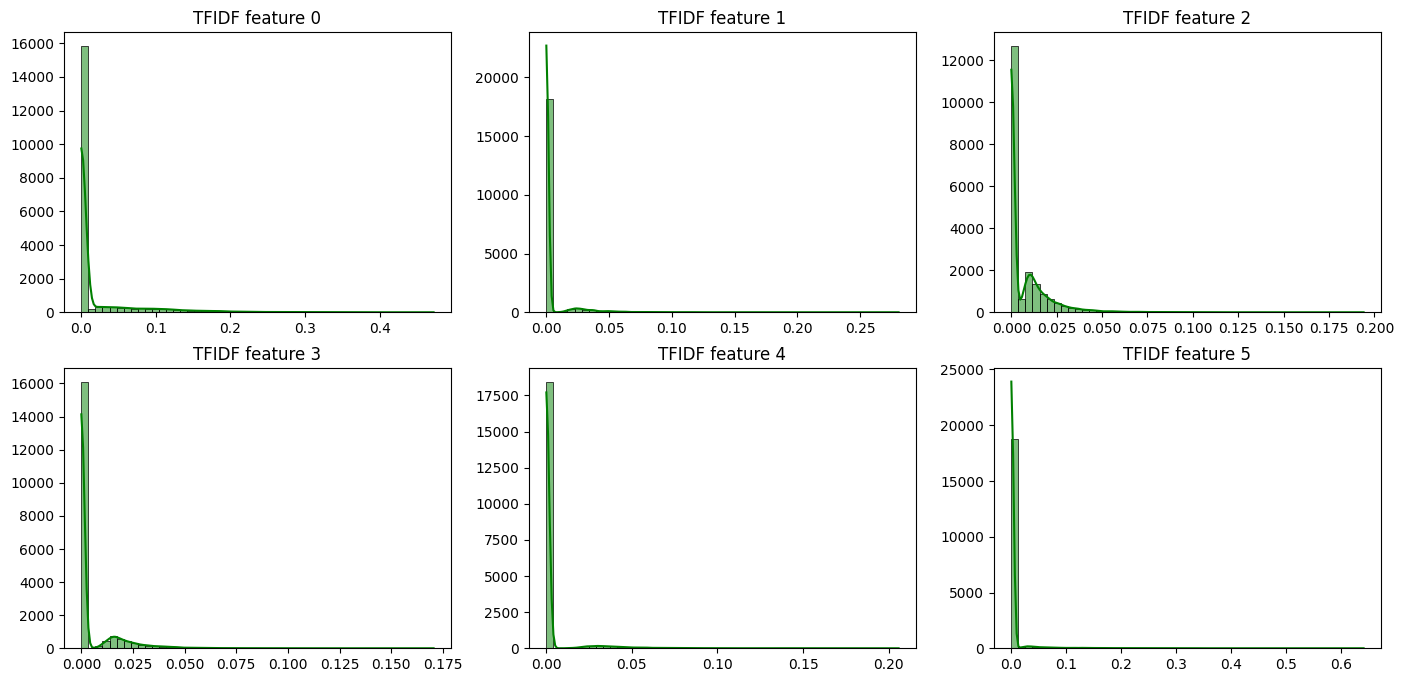

In [17]:
fig, axs = plt.subplots(2,3, figsize=(17,8))
for i in range(6):

    row = i // 3
    col = i % 3
    
    sns.histplot(nodes_TFIDF[:,i], kde=True, color='green', bins=50, ax=axs[row,col])
    axs[row,col].title.set_text(f'TFIDF feature {i}')
    axs[row,col].set_ylabel('')
    
plt.show()

Let's perform a simple dimensionality reduction pipeline to provide a visualization and eventually see if clusters naturally arises in the documents. 

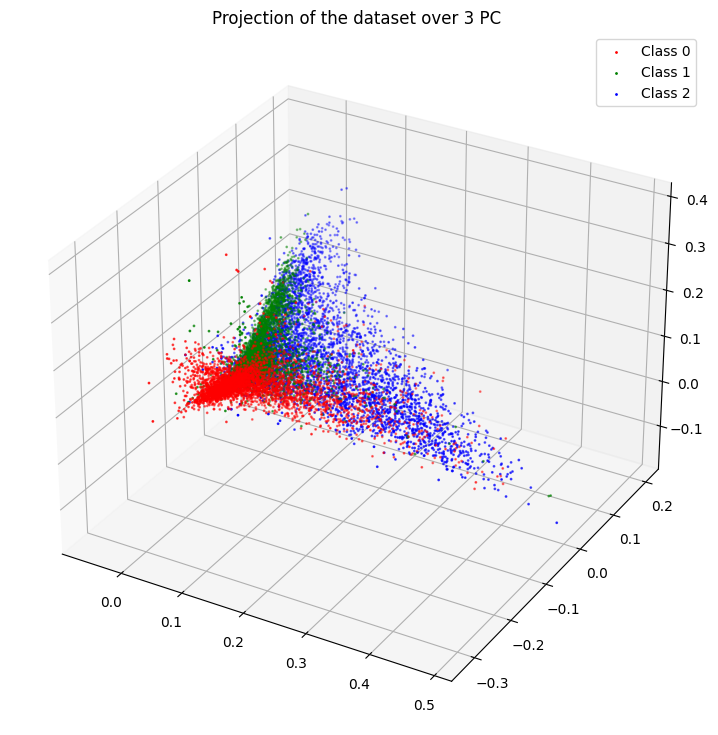

In [18]:
torch.manual_seed(0)

U, S, V = torch.pca_lowrank(nodes_TFIDF, q = 3)
projected = torch.matmul(nodes_TFIDF, V)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')

colors = ['r','g','b']

for i, color in enumerate(colors):
    ax.scatter(projected[nodes_classes == i, 0], projected[nodes_classes == i, 1], projected[nodes_classes == i, 2],
                color=color,
                s = 1,
                label=f'Class {i}')
    ax.legend()
    ax.title.set_text('Projection of the dataset over 3 PC')

Let's also have a look to the number of classes and their distribution: 

In [19]:
torch.unique(nodes_classes)

tensor([0, 1, 2])

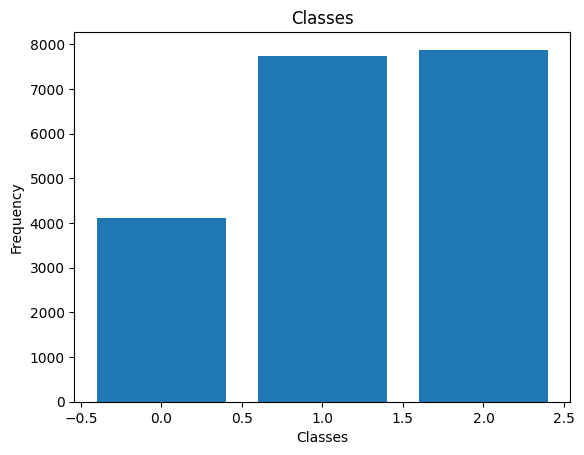

In [20]:
class_counts = Counter(nodes_classes.tolist())

# Extract classes and their frequencies
class_labels = list(class_counts.keys())
class_frequencies = list(class_counts.values())

# Plot bar plot
plt.bar(class_labels, class_frequencies)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Classes')
plt.show()

As we can see, the first class is way less represented, resulting over all in a quite unbalanced dataset that may result in an irreducible error. 

Lastly, let's assess the relation between the TFIDF features and the class: we will have a look to both the correlation coefficients and the weights of a logistic regression. Being a linear model, logistic regression is natively highly explainable just looking at the retrieved parameters.  

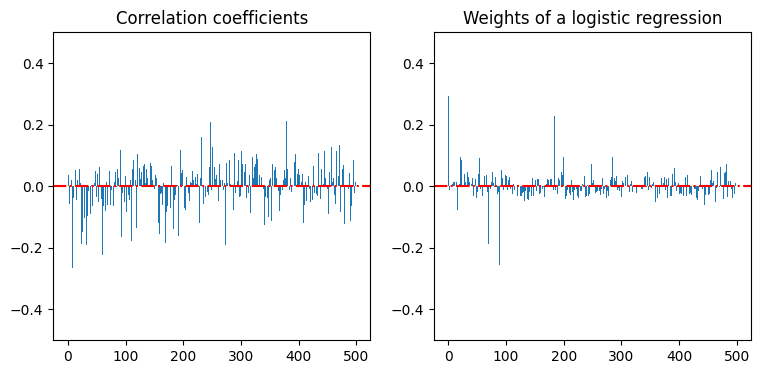

In [21]:
np.random.seed(42)

# Retrieve correlation coefficients

correlation_values = np.zeros(nodes_TFIDF.numpy().shape[1])

for i in range(nodes_TFIDF.shape[1]):
    column = nodes_TFIDF[:, i]
    correlation_values[i] = np.corrcoef(column, nodes_classes)[0,1]

# Retrieve weights of a logistic regression

model = LogisticRegression(max_iter=1000)
model.fit(nodes_TFIDF.numpy(), nodes_classes.numpy())

weights = model.coef_[0]
weights = weights/np.sum(weights)

# Plot the two retrieved sets 

fig, axs = plt.subplots(1,2,figsize=(9,4))

axs[0].set_ylim([-0.5,0.5])
axs[0].bar(np.arange(0,500),correlation_values)
axs[0].axhline(y = np.mean(correlation_values), color = 'r', linestyle = '-.')
axs[0].title.set_text('Correlation coefficients')

axs[1].set_ylim([-0.5,0.5])
axs[1].bar(np.arange(0,500),weights)
axs[1].axhline(y = np.mean(weights), color = 'r', linestyle = '-.')
axs[1].title.set_text('Weights of a logistic regression')

There is mostlty a negative correlation, but we would not expect a relation between such features and a class to be predictable through linear relation: actually, on average there's no correlation at all. 

Looking at the (normalized) weights of the logistic regression, we can say that some features are more relevant than others: however, we'll stop here and finally go through the core implementation of this problem.

## Graph neural networks for node classification 

### Graph convolutional network 

The main idea of a graph convolutional network (GCN), similarly to classical convolutional neural network (CNN), is to leverage localty in processing the input: this lead to the message passing aggregation among the neighboors. Moreover, what in CNN was the property of translational invariance, in GCN becomes permutational invariance: to do so, we define a shift operator $S$ properly encoding for the sparsity pattern of the graph. 

The simplest way to define a GCN is the stack of many graph convolutional layers, based on finite impulse response filters over graphs: this is intimately linked to graph spectral theory, since these filters as defined have an equivalent in the Fourier domain embedded in the shift operator. Recursively, we can write: 

$$ X^{(l)} = \sigma\{\sum_{k=0}^{K-1} S^kX^{(l-1)}H_k\} $$

where 
+ $\sigma$ is the usual nonlinearity function between subsequent layers;
+ $S$ is the shift operator;
+ $X^{(l-1)}$ is the input matrix of signals over the nodes for the subsequent layer $X^{(l)}$: $X^0$ is the original input data matrix;
+ $H$ is the tensor of parameters;
+ $K$ is the considered power for the shift operator, i.e. the number of hops in a single aggregation. 

Up to this definition, this architecture is task agnostic: in order to perform node classification, we add a softmax head to the top layer: equivalently, we leverage the fact that softmax can be implemented either as a layer or within the loss optimization routine. 
In the end, our model will look like:

$$ X^{(l)} = \sigma\{\sum_{k=0}^{K-1} S^kX^{(l-1)}H_k\}, \ \ \ l = 1,..., L  $$
$$ \mathrm{softmax}(X_u^{(L)}, y_u) = \sum_{i=1}^C y_u[i] \frac{\exp{(X_u^{(L)T}w_i)}}{\sum_{j=1}^C exp{(X_u^{(L)T}w_j)}}$$

### Baselines: GCN, SAGE, GAT

I've started with 2 layers architectures with a fully connected linear layer on top of them and a skip connection before it, with ReLU activation and edge dropout: to make the network more robust, I also added dropout on nodes features.
Then, since I couldn't reach the benchmark performances, I went for a lighter model with only two message passing layers and node features dropout. 

I experimented with the standard convolutional layer ```GCNConv``` implemented as a module in ```torch_geometric.nn```, as well as message passing variants ```SAGEConv``` and ```GATConv```: the three models are implemented in the module ```models_utils.py```.
The ```train_utils.py``` contains a simple training loop implementation with a call for early stopping. 

In [22]:
# GCN model instantiation

model_1 = GCNNet(
    in_channels=dataset.num_features,
    hidden_channels=256,
    out_channels=16,
    num_classes=dataset.num_classes
    ).float()

optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.01, weight_decay=3e-4)
model_1

GCNNet(
  (conv1): GCNConv(500, 256)
  (conv2): GCNConv(256, 16)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)

In [23]:
# SAGE model instantiation

model_2 = SAGENet(
    in_channels=dataset.num_features,
    hidden_channels=256,
    out_channels=16,
    num_classes=dataset.num_classes
    ).float()

optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.01, weight_decay=3e-4)

model_2

SAGENet(
  (conv1): SAGEConv(500, 256, aggr=mean)
  (conv2): SAGEConv(256, 16, aggr=mean)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)

In [24]:
# GAT model instantiation

model_3 = GATNet(
    heads = 3,
    in_channels=dataset.num_features,
    hidden_channels=256,
    out_channels=16,
    num_classes=dataset.num_classes
    ).float()

optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.01, weight_decay=3e-4)

model_3

GATNet(
  (conv1): GATConv(500, 256, heads=3)
  (conv2): GATConv(768, 16, heads=1)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)

In [25]:
GCN_train_loss, GCN_val_acc = node_classification_train_loop(model_1, 
                                                             optimizer_1, 
                                                             data,
                                                             100,
                                                             20,
                                                             'checkpoint1.pt')

Epoch: 5     | Training Loss: 0.8144 | Validation accuracy: 0.7340
Epoch: 10    | Training Loss: 0.3290 | Validation accuracy: 0.7580
Epoch: 15    | Training Loss: 0.1064 | Validation accuracy: 0.7820
Epoch: 20    | Training Loss: 0.0405 | Validation accuracy: 0.7860
Epoch: 25    | Training Loss: 0.0237 | Validation accuracy: 0.7980
Epoch: 30    | Training Loss: 0.0099 | Validation accuracy: 0.7900
Epoch: 35    | Training Loss: 0.0130 | Validation accuracy: 0.7820
Epoch: 40    | Training Loss: 0.0155 | Validation accuracy: 0.7720
Epoch: 45    | Training Loss: 0.0250 | Validation accuracy: 0.7900
Early stopping at epoch 45 with best validation accuracy: 0.7980
Calling back best model...


In [26]:
SAGE_train_loss, SAGE_val_acc = node_classification_train_loop(model_2, 
                                                               optimizer_2, 
                                                               data,
                                                               200,
                                                               10,
                                                               'checkpoint2.pt')

Epoch: 5     | Training Loss: 0.5563 | Validation accuracy: 0.7220
Epoch: 10    | Training Loss: 0.1258 | Validation accuracy: 0.7520
Epoch: 15    | Training Loss: 0.0259 | Validation accuracy: 0.7660
Epoch: 20    | Training Loss: 0.0089 | Validation accuracy: 0.7740
Epoch: 25    | Training Loss: 0.0056 | Validation accuracy: 0.7820
Epoch: 30    | Training Loss: 0.0074 | Validation accuracy: 0.7700
Epoch: 35    | Training Loss: 0.0041 | Validation accuracy: 0.7700
Early stopping at epoch 36 with best validation accuracy: 0.7840
Calling back best model...


In [27]:
GAT_train_loss, GAT_val_acc = node_classification_train_loop(model_3, 
                                                             optimizer_3, 
                                                             data,
                                                             200,
                                                             10,
                                                             'checkpoint3.pt')

Epoch: 5     | Training Loss: 0.6247 | Validation accuracy: 0.7440
Epoch: 10    | Training Loss: 0.1828 | Validation accuracy: 0.7780
Epoch: 15    | Training Loss: 0.0566 | Validation accuracy: 0.7760
Epoch: 20    | Training Loss: 0.0298 | Validation accuracy: 0.7960
Epoch: 25    | Training Loss: 0.0175 | Validation accuracy: 0.7520
Epoch: 30    | Training Loss: 0.0114 | Validation accuracy: 0.7820
Early stopping at epoch 30 with best validation accuracy: 0.7960
Calling back best model...


Let's test the models: 

In [28]:
_, _, GCN_test_acc = node_classification_test(model_1, data)
_, _, SAGE_test_acc = node_classification_test(model_2, data)
_, _, GAT_test_acc = node_classification_test(model_3, data)

print(f'GCN test accuracy:  {GCN_test_acc:.04f}')
print(f'SAGE test accuracy: {SAGE_test_acc:.04f}')
print(f'GAT test accuracy:  {GAT_test_acc:.04f}')

GCN test accuracy:  0.7840
SAGE test accuracy: 0.7600
GAT test accuracy:  0.7700


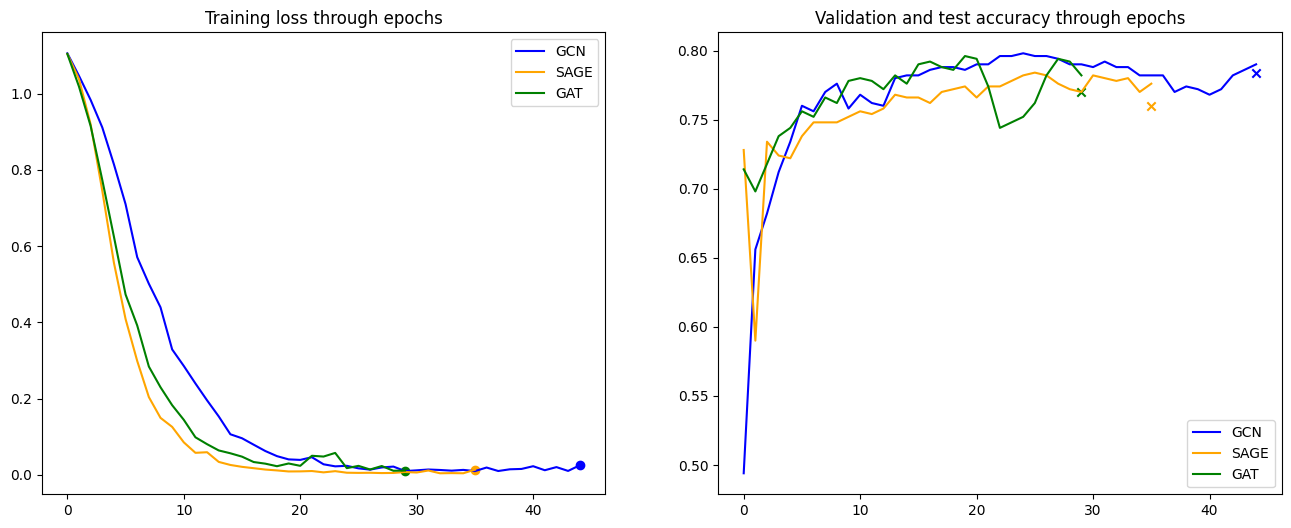

In [29]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

axs[0].plot(GCN_train_loss, label='GCN', color='blue')
axs[0].plot(SAGE_train_loss, label='SAGE', color='orange')
axs[0].plot(GAT_train_loss, label='GAT', color='green')
axs[0].scatter(len(GCN_train_loss) - 1, GCN_train_loss[-1], color='blue', marker='o')
axs[0].scatter(len(SAGE_train_loss) - 1, SAGE_train_loss[-1], color='orange', marker='o')
axs[0].scatter(len(GAT_train_loss) - 1, GAT_train_loss[-1], color='green', marker='o')
axs[0].title.set_text('Training loss through epochs')
axs[0].legend()

axs[1].plot(GCN_val_acc, label='GCN', color='blue')
axs[1].plot(SAGE_val_acc, label='SAGE', color='orange')
axs[1].plot(GAT_val_acc, label='GAT', color='green')
axs[1].scatter(len(GCN_val_acc) - 1, GCN_test_acc, color='blue', marker='x')
axs[1].scatter(len(SAGE_val_acc) - 1, SAGE_test_acc, color='orange', marker='x')
axs[1].scatter(len(GAT_val_acc) - 1, GAT_test_acc, color='green', marker='x')
axs[1].title.set_text('Validation and test accuracy through epochs')
axs[1].legend()

## Graph neural networks for link predictions

The idea for link prediction is to learn the node embedding as the output of a message passing network and then define a binary classification task whose training loop would be based on the following empirical loss function: 

$$\mathcal{L} = - \sum_{u \sim v \in \mathcal{D}} (y_{u\sim v} \log(\hat{y}_{u \sim v}) + (1 - y_{u \sim v} \log(1 - \hat{y}_{u \sim v}))) $$

where we basically compare the binary cross entropy between the ground truth adjacency matrix and reconstructed one. 

So the architecture would result from the chaining of two distinct models: 
+ An encoder based on a GNN computing node-level embedding representations;
+ A decoder based on a dot product similarity between the learned node embeddings. 


In order to do so, we need to define a proper splitting for the edge set in a training set, a validation set and a test set following the usual proportion 

$0.8:0.1:0.1$.

We do the same for edges that are not present: they define the negative graph and are fundamental to build a robust model. This routine will be handled by ```torch_geometric.utils``` built in ```negative_sampling```.

In [30]:
nodes = torch.arange(0, data.x.shape[0])
edges = data.edge_index

pos_edges_train, pos_edges_val, pos_edges_test = edge_splitting(edges, nodes)
neg_edges_train, neg_edges_val, neg_edges_test = edge_splitting(edges, nodes, negative=True)

Now we first instantiate a model that will work as our encoder-decoder: it is a GCN with a decoder on top computing dot product of node embeddings and wrapping them in a sigmoid.  

In [31]:
hidden_channels = 128
embedding_dimension = 16

model = EncoderDecoder(
    in_channels=dataset.num_features,
    hidden_channels=hidden_channels,
    out_channels=embedding_dimension
    ).float()

model

EncoderDecoder(
  (conv1): GCNConv(500, 128)
  (conv2): GCNConv(128, 16)
)

Finally we can start our training loop. 

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

epochs = 40

In [33]:
train_loss, val_auc = encoder_decoder_train_loop(epochs,
                                                 model,
                                                 optimizer,
                                                 criterion,
                                                 data,
                                                 pos_edges_train,
                                                 neg_edges_train,
                                                 pos_edges_val,
                                                 neg_edges_val)

Epoch: 0     | Training Loss: 0.6928 | AUC-ROC Score: 0.9068
Epoch: 5     | Training Loss: 0.6274 | AUC-ROC Score: 0.8891
Epoch: 10    | Training Loss: 0.5724 | AUC-ROC Score: 0.9247
Epoch: 15    | Training Loss: 0.5398 | AUC-ROC Score: 0.8692
Epoch: 20    | Training Loss: 0.5153 | AUC-ROC Score: 0.9080
Epoch: 25    | Training Loss: 0.4833 | AUC-ROC Score: 0.9429
Epoch: 30    | Training Loss: 0.4834 | AUC-ROC Score: 0.9378
Epoch: 35    | Training Loss: 0.4689 | AUC-ROC Score: 0.9498


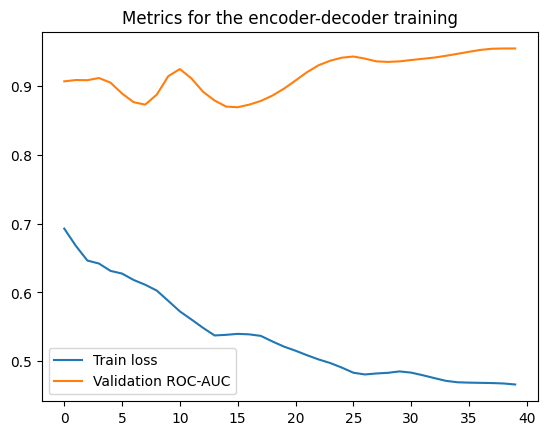

In [34]:
plt.plot(train_loss, label = 'Train loss')
plt.plot(val_auc, label = 'Validation ROC-AUC')
plt.title('Metrics for the encoder-decoder training')
plt.legend()

Let's test the model: 

In [35]:
test_encoder_decoder(model,
                     data,
                     pos_edges_test,
                     neg_edges_test)

Test AUC-ROC Score: 0.9551


In this case meeting the benchmark score was easier with a very simple architecture.